<a href="https://colab.research.google.com/github/firdarinoa/bangkit-assignment5/blob/master/Backpainclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Copyright 2020 Google LLC. Double-click here for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lower back Pain Classification.


Lower back pain can be caused by a variety of problems with any parts of the complex, interconnected network of spinal muscles, nerves, bones, discs or tendons in the lumbar spine. An irritation or problem with any of these structures can cause lower back pain and/or pain that radiates or is referred to other parts of the body.Â Â 

A serious condition of lower back pain could lead to back surgery. It can be done by a minimally invasive surgery, althoughÂ  thereâ€™s also risks that may come up. Dvorak et al studied 575 patients with symptomatic lumbar disc herniation (LDH) who underwent surgical procedures and found that 255 (70%) still complained of back pain, with 83 (23%) reporting constant heavy pain and 172 patients (45%) presenting with residual sciatica.Â 

According to a post from Washington Post (2007, link), more than 20 percent of patients who sought a second opinion at one of the nationâ€™s premier medical institutions had been misdiagnosed by their primary care providers. A second opinion is valuable any time a patient is told he or she has a serious condition, such as cancer, or needs surgery, but second opinion means more expense for the extra visit.

Therefore there is a need of robust method to judge lower back condition to avoid human cognitive mistakes. In this project, we want to build ML model that could classify patient lower back pain condition into normal or abnormal condition, with 80% of second judgements from trusted orthopedist suit the ML result.


# Import module


First things to do is to import all the libraries needed.

In [0]:
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.data import Dataset
from tensorflow.keras import optimizers
from tensorflow.keras import layers
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm

# Import Dataset

Then, import the datasets, and see what’s in it. By doing this, we can look some statistical values of our data set.

In [65]:
df = pd.read_csv('Dataset_spine.csv')
df.head(10)

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,0.789993,29.3230,12.0036,10.40462,-1.512209,9.6548,Abnormal,Attribute1 = pelvic_incidence (numeric)
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,0.198920,13.8514,10.7146,11.37832,-20.510434,25.9477,Abnormal,Attribute2 = pelvic_tilt (numeric)
7,45.366754,10.755611,29.038349,34.611142,117.270068,-10.675871,0.131973,28.8165,7.7676,7.60961,-25.111459,26.3543,Abnormal,Attribute3 = lumbar_lordosis_angle (numeric)
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,0.190408,22.7085,11.4234,10.59188,-20.020075,40.0276,Abnormal,Attribute4 = sacral_slope (numeric)
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,0.367700,26.2011,8.7380,14.91416,-1.702097,21.4320,Abnormal,Attribute5 = pelvic_radius (numeric)


There's few changes must be done

In [66]:
# Changing column name

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.rename(columns = {
    "Col1" : "pelvic_incidence", 
    "Col2" : "pelvic_tilt",
    "Col3" : "lumbar_lordosis_angle",
    "Col4" : "sacral_slope", 
    "Col5" : "pelvic_radius",
    "Col6" : "degree_spondylolisthesis", 
    "Col7" : "pelvic_slope",
    "Col8" : "direct_tilt",
    "Col9" : "thoracic_slope", 
    "Col10" :"cervical_tilt", 
    "Col11" : "sacrum_angle",
    "Col12" : "scoliosis_slope", 
    "Class_att" : "Class_att"}, inplace=True)

df['Class_att'].replace({"Abnormal": True, "Normal": False}, inplace=True)
df['Class_att'] = df['Class_att'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   pelvic_slope              310 non-null    float64
 7   direct_tilt               310 non-null    float64
 8   thoracic_slope            310 non-null    float64
 9   cervical_tilt             310 non-null    float64
 10  sacrum_angle              310 non-null    float64
 11  scoliosis_slope           310 non-null    float64
 12  Class_att                 310 non-null    float64
dtypes: float64(13)
memory usage: 31.6 KB


It can be seen that there's no null value in the dataset.

In [0]:
# Splitting Dataset

df_train, df_test = train_test_split(df, test_size=0.2)
df_train = df_train.reindex(np.random.permutation(df_train.index))

# Feature Engineering

In [0]:
# Function to Calculate the Z-Scores of each columns in df_feature
def normalize(df, df_feature):
    for i in df_feature.columns:
        df[i] = (df[i]-df[i].mean())/df[i].std()
    return df

In [69]:
# Calculate the Z-scores of each column in the training set and testing set

df_feature = df.drop(['Class_att'], axis=1)
df_train_norm = normalize(df_train, df_feature)
df_test_norm = normalize(df_test, df_feature)
# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
df_train_norm.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
82,1.601666,1.088923,-0.247783,1.270607,0.273759,0.849342,0.975839,-0.929165,0.191743,1.164717,0.760297,0.685778,1.0
25,-0.393062,0.853874,-0.897498,-1.212998,0.249654,-0.771535,1.538191,-0.756033,0.165554,1.463934,-0.314636,0.229104,1.0
227,0.035712,0.181818,0.035160,-0.098304,0.040235,-0.666869,-1.010985,-0.776904,-1.617100,0.063581,-0.499144,1.532586,0.0
27,-1.002713,-0.123497,-0.277748,-1.244167,-0.673923,-0.532068,0.348155,1.100525,1.460254,-0.397197,-0.919355,-0.721114,1.0
155,0.340087,-0.312126,1.054390,0.706547,-2.708052,0.522795,0.859917,0.416123,-0.148616,-0.008483,0.489858,1.341389,1.0


# Data Analysis

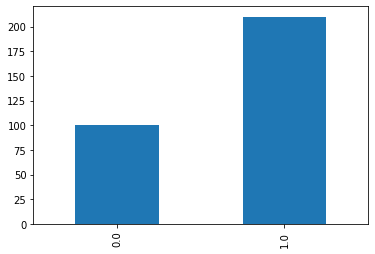

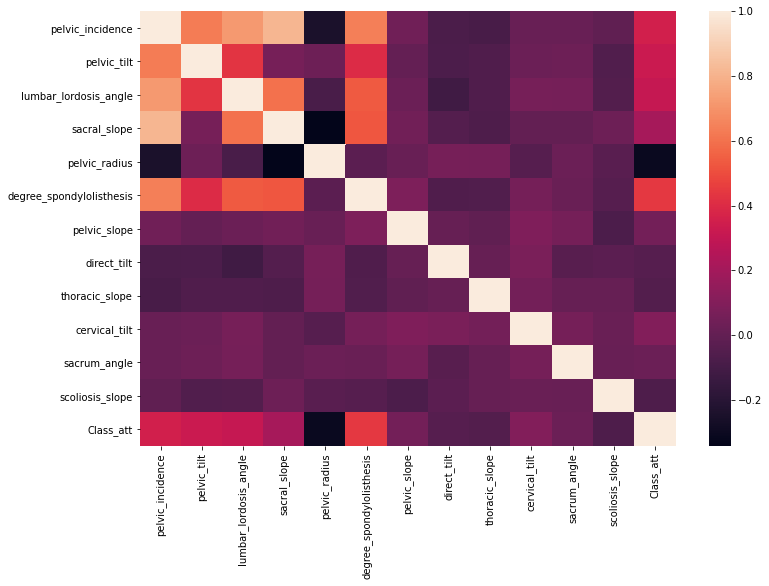

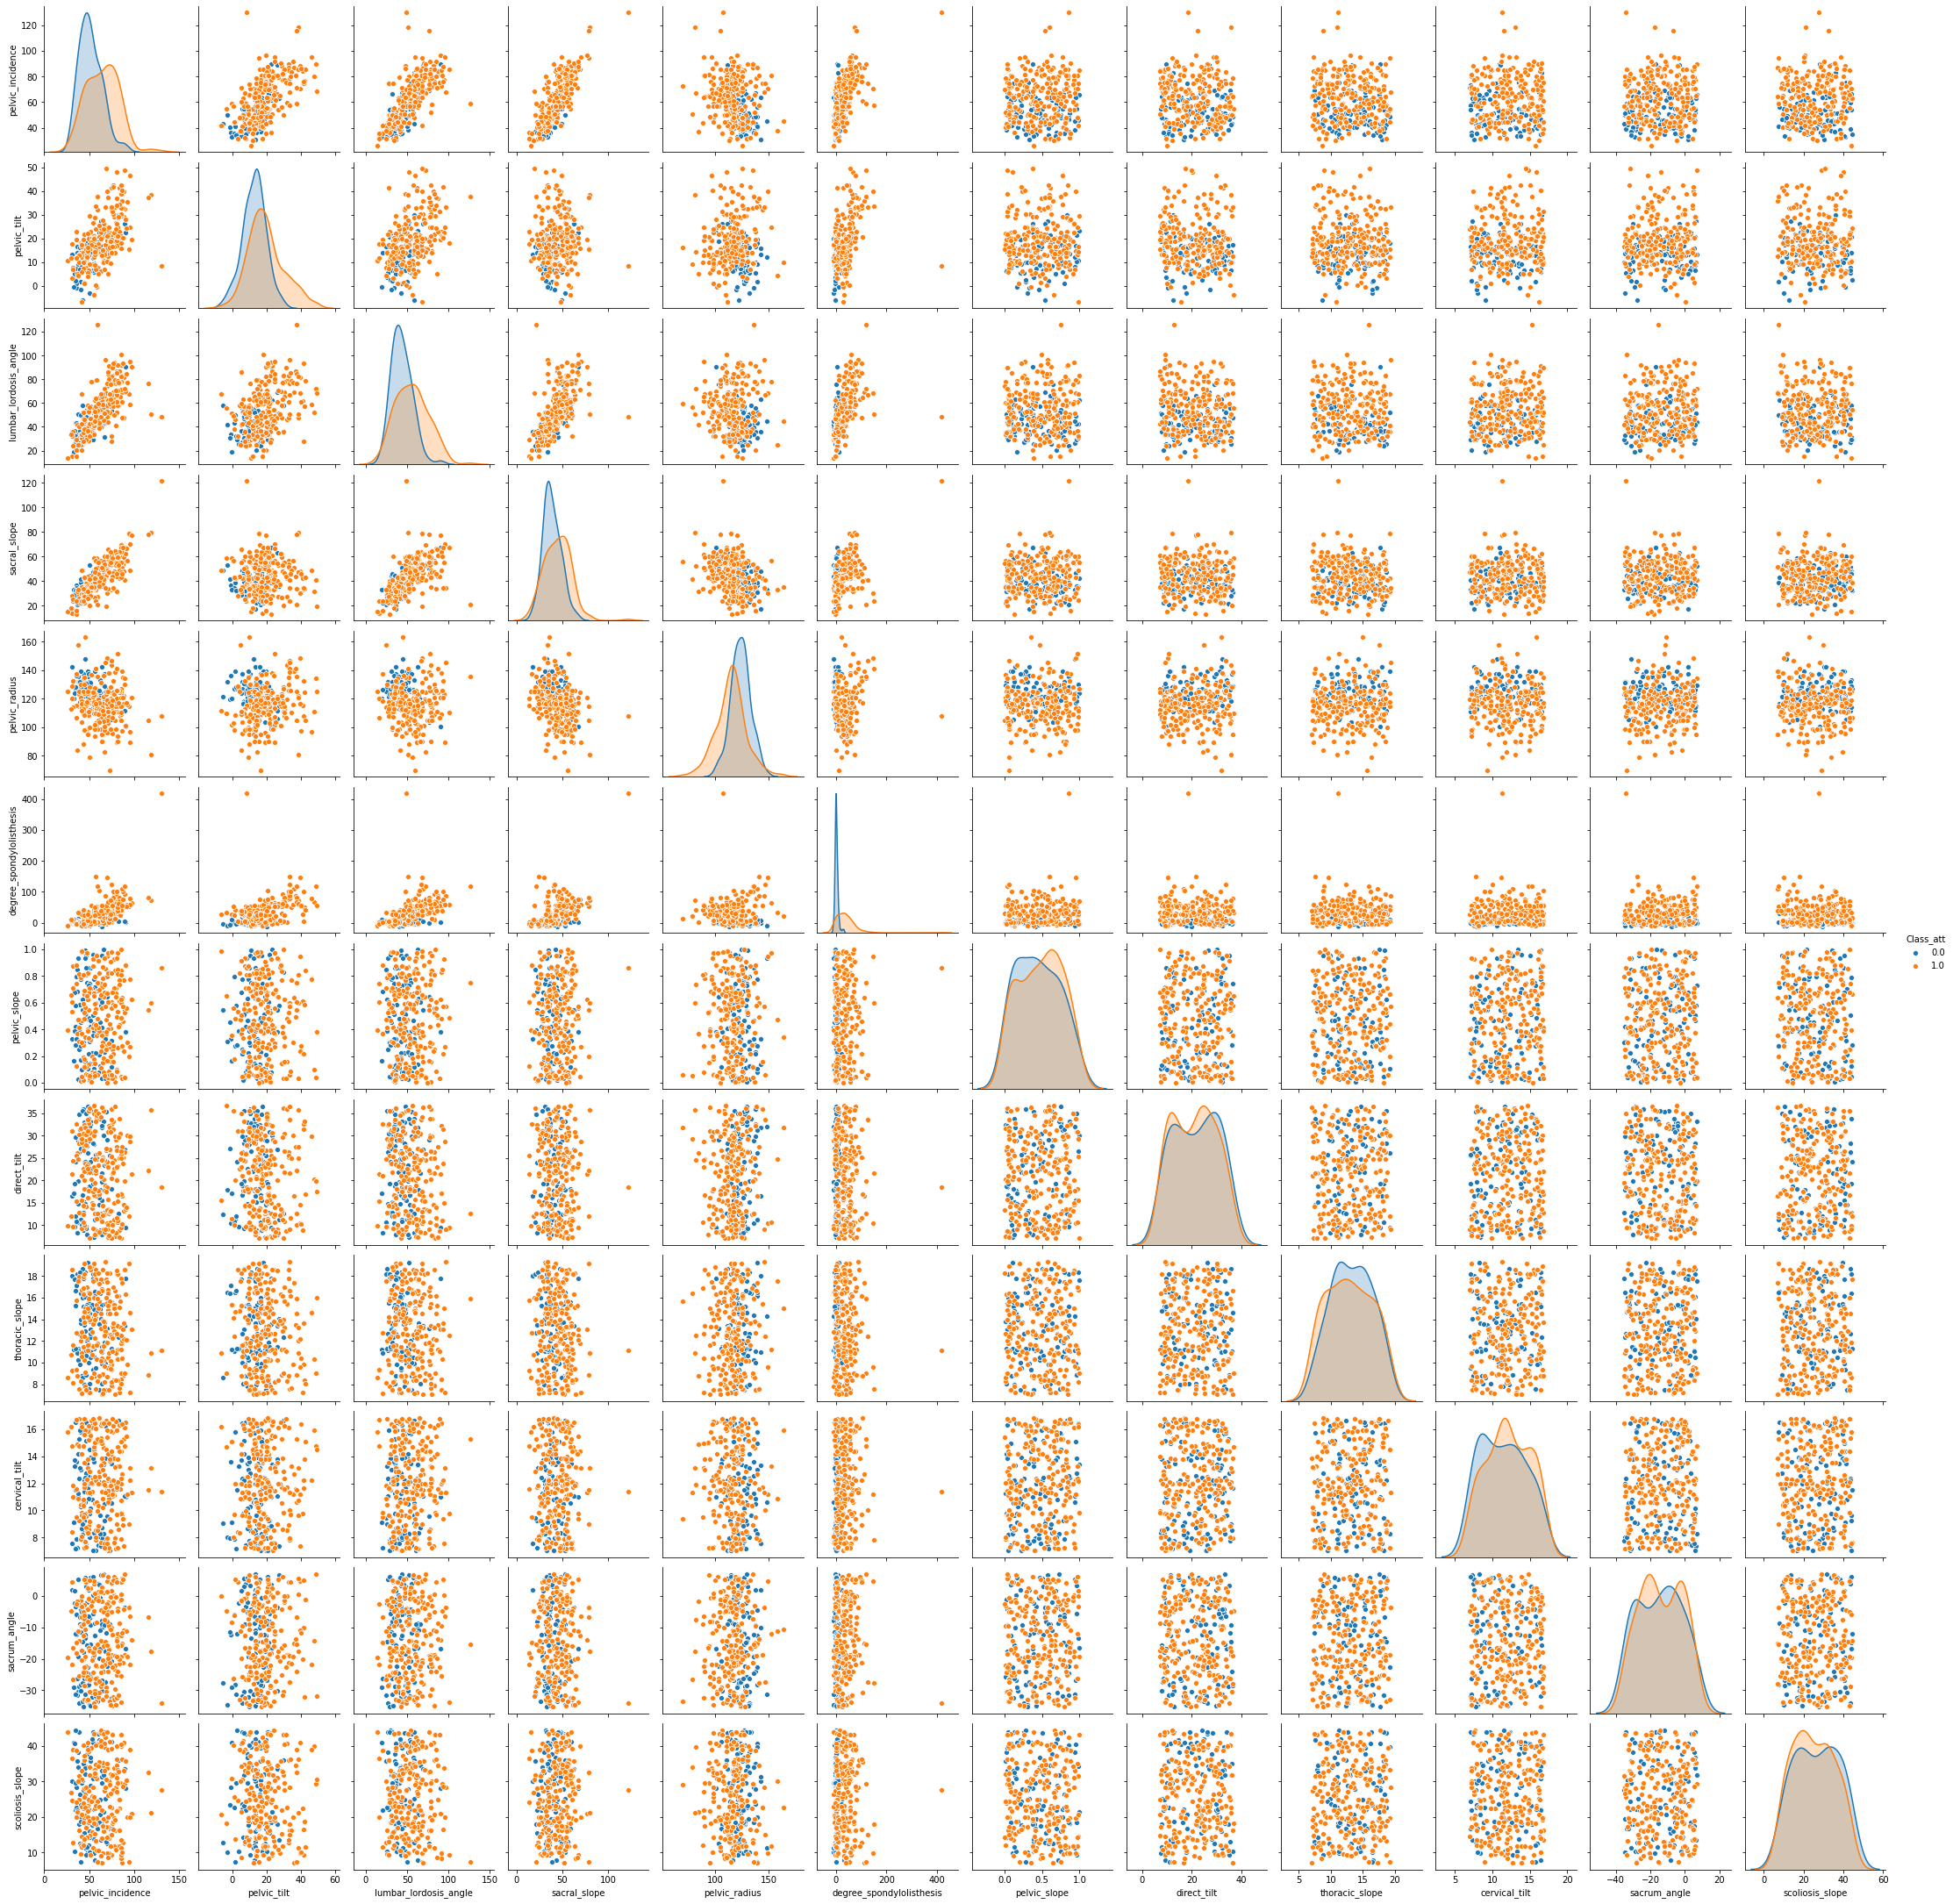

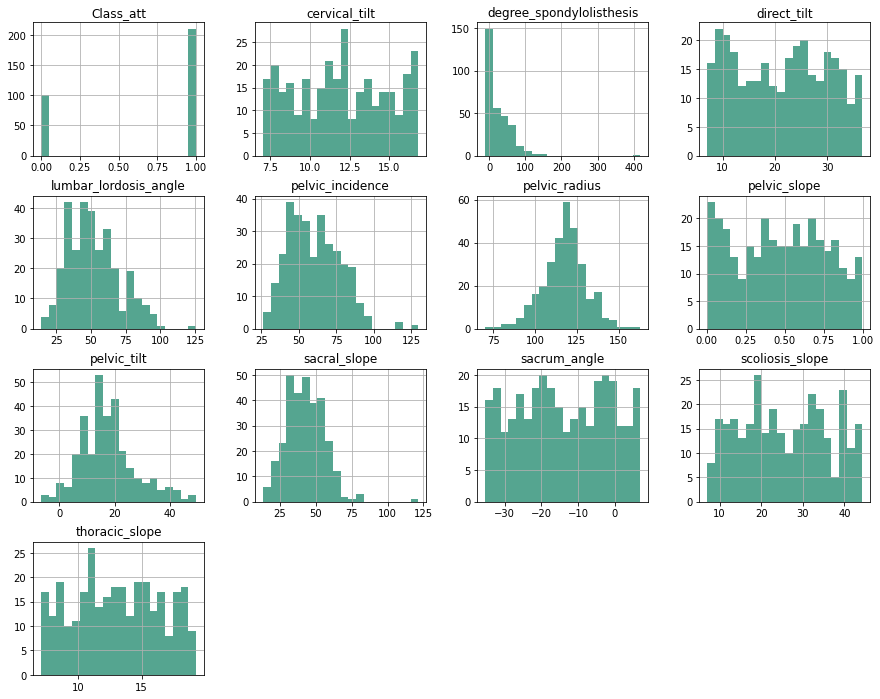

In [70]:
# Exploratory data analysis done to get overview of the data
def eda(df, feature):
    df["Class_att"].value_counts().sort_index().plot.bar()

    plt.subplots(figsize=(12,8))
    sns.heatmap(df.corr())

    sns.pairplot(df, hue="Class_att")

    df.hist(figsize=(15,12),bins = 20, color="#007959AA")
    plt.title("Features Distribution")
    plt.show()

eda(df, 'Class_att')

EDA Result.

In [0]:
# based on the above diagram, we choose some features that more relate with label  
# pelvic incidence is not choosen because linearly dependent to pelvic tilt and sacral slope, it might give false weight due redundance

feature_set = ['pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']
def tf_feature_columns(input_features):
    feature_columns = []
    for my_feature in input_features:
        feature_columns.append(tf.feature_column.numeric_column(my_feature))
    return feature_columns

#feature Layer Creation

tf_feature_columns = tf_feature_columns(feature_set)
feature_layer = layers.DenseFeatures(tf_feature_columns)
#feature_layer(dict(df_train_norm))

# Define Model & Training Function

In [73]:
# After few times tweaking the the hyperparameters, and based on distribution on EDA,
# The model could generate good result with linear model

def create_model(my_learning_rate, feature_layer, my_metrics):

  model = tf.keras.models.Sequential()


  model.add(feature_layer)

# Implement L2 regularization in the first hidden layer.
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden1'))
  
  # Implement L2 regularization in the second hidden layer.
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden2'))
  
  model.add(tf.keras.layers.Dense(units=1, activation=tf.sigmoid),)

  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True, my_validation_split=0.2):

  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_split = my_validation_split)
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


# Plotting Function

In [74]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


In [75]:
#@title Define the plotting function

def plot_the_loss_curve(epochs, mae_training, mae_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Binary Loss")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


# Prediction

In [0]:
# Hyperparameter Tuning
learning_rate = 0.001
epochs = 180
batch_size = 35
label_name = "Class_att"
classification_threshold = 0.5

Epoch 1/180
6/6 [==============================] - 0s 62ms/step - loss: 1.6538 - accuracy: 0.4394 - auc: 0.4397 - val_loss: 1.5777 - val_accuracy: 0.6000 - val_auc: 0.6137
Epoch 2/180
6/6 [==============================] - 0s 13ms/step - loss: 1.5784 - accuracy: 0.5505 - auc: 0.5391 - val_loss: 1.5207 - val_accuracy: 0.6400 - val_auc: 0.7135
Epoch 3/180
6/6 [==============================] - 0s 13ms/step - loss: 1.5237 - accuracy: 0.6111 - auc: 0.6207 - val_loss: 1.4752 - val_accuracy: 0.6800 - val_auc: 0.7830
Epoch 4/180
6/6 [==============================] - 0s 14ms/step - loss: 1.4787 - accuracy: 0.6768 - auc: 0.6731 - val_loss: 1.4322 - val_accuracy: 0.7400 - val_auc: 0.8307
Epoch 5/180
6/6 [==============================] - 0s 13ms/step - loss: 1.4375 - accuracy: 0.7071 - auc: 0.7237 - val_loss: 1.3926 - val_accuracy: 0.7400 - val_auc: 0.8759
Epoch 6/180
6/6 [==============================] - 0s 13ms/step - loss: 1.3990 - accuracy: 0.7071 - auc: 0.7667 - val_loss: 1.3542 - val_acc

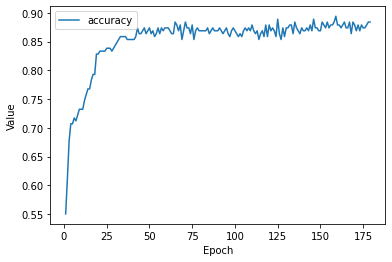

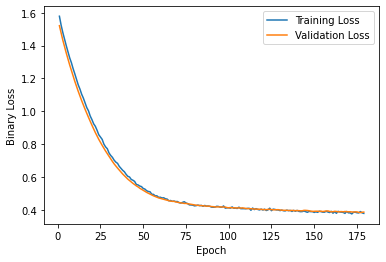

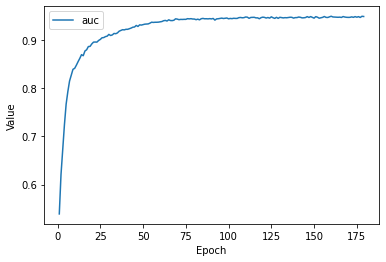

In [83]:
# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                           threshold=classification_threshold),
           tf.keras.metrics.AUC(num_thresholds=100, name='auc')
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, df_train_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

# Plot loss curve
plot_curve(epochs, hist, list_of_metrics_to_plot)
plot_the_loss_curve(epochs, hist["loss"], hist["val_loss"])

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Model Testing

In [84]:
# Evaluate the model against the test set
features = {name:np.array(value) for name, value in df_test_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

2/2 [==============================] - 0s 2ms/step - loss: 0.5023 - accuracy: 0.8226 - auc: 0.8970


[0.5023096799850464, 0.8225806355476379, 0.8970237970352173]

# Result

In [85]:
for layer in my_model.layers:
  weights = layer.get_weights()

weights

[array([[ 1.2392772 ],
        [-0.96570504],
        [ 1.0384009 ],
        [ 1.4179502 ],
        [-1.1546903 ],
        [ 0.80620784],
        [ 1.5203679 ],
        [-0.7733454 ],
        [-1.1757616 ],
        [ 0.69466496],
        [ 0.96902716],
        [ 0.7874139 ]], dtype=float32), array([0.10280354], dtype=float32)]